In [429]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [430]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
df = train.append(test).reset_index()


In [431]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in "SalePrice"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols, num_but_cat


cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 82
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


In [432]:

def outlier_thresholds(dataframe, variable, low_quantile=0.01, up_quantile=0.99):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [433]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if
                         data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x,
                      axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

In [434]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

              n_miss  ratio
PoolQC          2909 99.660
MiscFeature     2814 96.400
Alley           2721 93.220
Fence           2348 80.440
SalePrice       1459 49.980
FireplaceQu     1420 48.650
LotFrontage      486 16.650
GarageCond       159  5.450
GarageYrBlt      159  5.450
GarageFinish     159  5.450
GarageQual       159  5.450
GarageType       157  5.380
BsmtExposure      82  2.810
BsmtCond          82  2.810
BsmtQual          81  2.770
BsmtFinType2      80  2.740
BsmtFinType1      79  2.710
MasVnrType        24  0.820
MasVnrArea        23  0.790
MSZoning           4  0.140
Functional         2  0.070
BsmtHalfBath       2  0.070
BsmtFullBath       2  0.070
Utilities          2  0.070
KitchenQual        1  0.030
TotalBsmtSF        1  0.030
BsmtUnfSF          1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
BsmtFinSF2         1  0.030
BsmtFinSF1         1  0.030
Exterior2nd        1  0.030
Exterior1st        1  0.030
SaleType           1  0.030
Electrical         1

In [435]:
df["MSZoning"] = np.where(df.LotShape.isin(["C (all)", "RH"]), "CRH", df["MSZoning"])
df["Fireplaces"] = np.where(df.LotShape.isin(["4", "3"]), "43", df["Fireplaces"])
df["GarageCars"] = np.where(df.LotShape.isin(["4.000", "5.000"]), "45", df["GarageCars"])
df["Condition1"] = np.where(df.LotShape.isin(["RRNn", "RRNe","RRAn"]), "RRR", df["Condition1"])
df["Exterior2nd"] = np.where(df.LotShape.isin(["AsbShng", "AsphShn"]), "AA", df["Exterior2nd"])
df["Exterior2nd"] = np.where(df.LotShape.isin(["Brk Cmn", "BrkFace"]), "BB", df["Exterior2nd"])
df["Exterior2nd"] = np.where(df.LotShape.isin(["Other", "Stone","CBlock"]), "OSC", df["Exterior2nd"])
df["Total_Floor"] = df["1stFlrSF"] + df["2ndFlrSF"]
df["Build"] =df["YearRemodAdd"]- df["YearBuilt"]
df["Std_Build"] = df[["YearRemodAdd","YearBuilt"]].std()
df["_Floor_cross"] = df["1stFlrSF"] * df["2ndFlrSF"]
df['Build'].replace(-1, np.nan, inplace= True)
df.drop("PoolArea", axis=1, inplace=True)
drop_list = ["MiscFeature","Fence","PoolQC","GarageCond","GarageQual","FireplaceQu"]
df.drop("Alley", axis=1, inplace=True)
df.drop(drop_list, axis=1, inplace=True)
df.drop("Heating", axis=1, inplace=True)
df.drop("index", axis=1, inplace=True)
df["GarageYrBlt"].fillna(df["GarageYrBlt"].mode())


0      2003.000
1      1976.000
2      2001.000
3      1998.000
4      2000.000
5      1993.000
6      2004.000
7      1973.000
8      1931.000
9      1939.000
10     1965.000
11     2005.000
12     1962.000
13     2006.000
14     1960.000
15     1991.000
16     1970.000
17     1967.000
18     2004.000
19     1958.000
20     2005.000
21     1930.000
22     2002.000
23     1976.000
24     1968.000
25     2007.000
26     2005.000
27     2008.000
28     1957.000
29     1920.000
30     1920.000
31     1966.000
32     2007.000
33     1959.000
34     2005.000
35     2004.000
36     1995.000
37     1954.000
38     1953.000
39     2005.000
40     1965.000
41     1959.000
42     1983.000
43     1977.000
44     1959.000
45     2005.000
46     2003.000
47     2006.000
48     2005.000
49     1966.000
50     1997.000
51     1985.000
52     1963.000
53     1981.000
54     1962.000
55     1964.000
56     1999.000
57     2004.000
58     2006.000
59     1973.000
60     2006.000
61     1935.000
62     2

In [436]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 76
cat_cols: 45
num_cols: 29
cat_but_car: 1
num_but_cat: 9


In [437]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

Observations: 2919
Variables: 76
cat_cols: 45
num_cols: 29
cat_but_car: 1
num_but_cat: 9


In [438]:
Year_col = [col for col in df[num_cols] if "Year" in col]
Year_col

['YearBuilt', 'YearRemodAdd']

In [439]:
aggregations_MS = {"LotFrontage":["sum","mean"],
                    "LotArea": ["min", "mean","sum","max"],
                    "Street":["nunique", "size"],
                     "LandContour": ["nunique"],
                    "LandSlope": ["nunique"],
                     "GrLivArea":["std","var"]}

 

In [440]:
 MSZoning = df.groupby('MSZoning').agg(aggregations_MS)

In [441]:
 MSZoning.columns = pd.Index(['MSZoning' + e[0] + "_" + e[1].upper() for e in MSZoning.columns.tolist()])
 
 df.drop(["LotFrontage","MiscVal", "LotArea", "Street", "LandContour", "LandSlope" ],axis=1, inplace=True)
    
 
 df = df.join(MSZoning, how='left', on='MSZoning')   

In [442]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 82
cat_cols: 54
num_cols: 26
cat_but_car: 1
num_but_cat: 21


In [446]:
aggregations_BC = {"GarageArea":["sum","mean"],
                    "WoodDeckSF": ["mean","sum","max"],
                    "OpenPorchSF":["min", "mean","sum","max"],
                     "TotRmsAbvGrd": ["mean", "size"],
                    "TotalBsmtSF": ["mean","sum","max"],
                     "GrLivArea": ["min", "max", "size"],
                      "Build" : ["min","max"],
                       "1stFlrSF": ["var","mean","max", "std"],
                       "2ndFlrSF" : ["var", "std", "mean","min"],
                       "EnclosedPorch": ["min", "max"] }

In [447]:
MSSubClass = df.groupby('MSSubClass').agg(aggregations_BC)

In [448]:
 MSSubClass.columns = pd.Index(['MSSubClass' + e[0] + "_" + e[1].upper() for e in MSSubClass.columns.tolist()])

In [449]:
 df.drop(["EnclosedPorch","2ndFlrSF","1stFlrSF","Build", "GarageArea", "WoodDeckSF", "OpenPorchSF", "GrLivArea", "TotRmsAbvGrd", "TotalBsmtSF" ],axis=1, inplace=True)

In [450]:
df = df.join(MSSubClass, how='left', on='MSSubClass')   

In [451]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 101
cat_cols: 58
num_cols: 41
cat_but_car: 1
num_but_cat: 25


In [452]:
def one_hot_encoder(df, drop_first=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, drop_first=drop_first)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [453]:
df, cat_colls = one_hot_encoder(df)

In [457]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [456]:
del df["Std_Build"]

In [350]:
train_df.dropna(inplace=True)

In [458]:
X =train_df.drop(["SalePrice", "Id"], axis=1)
y = np.log1p(train_df['SalePrice'])


In [459]:
X.shape, test_df.shape

((1460, 251), (1459, 253))

In [460]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [465]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model,
                                        X, y, cv=10, scoring="neg_mean_squared_error")))


In [467]:
lgbm_params = {"learning_rate": [0.01,0.02, 0.04, 0.05, 0.1],
               "n_estimators": [500, 1500,2000, 5000, 6000, 7000, 8000, 9000, 10000, 15000],
                    }
 
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [468]:

final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))

In [469]:
rmse

0.13405946626598658

In [471]:
lgbm_tuned = LGBMRegressor(**lgbm_gs_best.best_params_).fit(X_train, y_train)
y_pred = lgbm_tuned.predict(X_test)

In [222]:
## Log dönüşüm tersi
new_y= np.expm1(y_pred)
new_y_test= np.expm1(y_test)

In [472]:
test_dff = test_df.drop(["SalePrice", "Id"], axis=1)

In [473]:
test_dff.shape

(1459, 251)

In [474]:
y_predd = lgbm_tuned.predict(test_dff)

In [475]:
new_y= np.expm1(y_predd)


In [476]:
my_submission = pd.DataFrame({'Id': test_df["Id"], 'SalePrice': new_y})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_.csv', index=False)

In [477]:
sub = pd.read_csv("./submission_.csv")

In [478]:
sub = sub.astype("int")


In [479]:
sub.to_csv('submission__.csv', index=False)

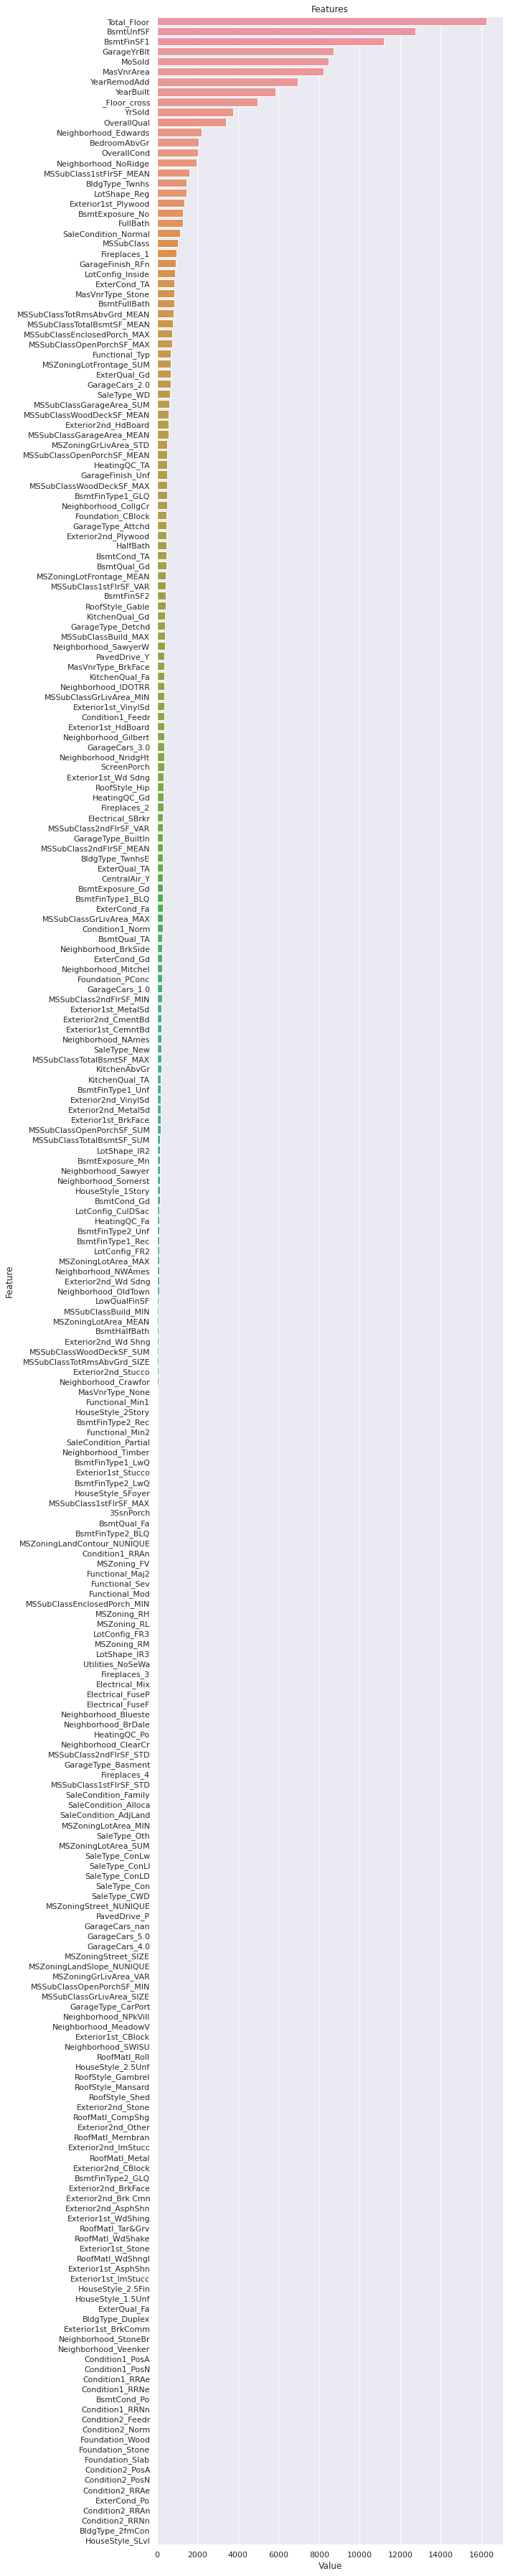

In [480]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 50))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
plot_importance(lgbm_tuned, X)